In [1]:
# Importing librarie
 
import pandas as pd
import numpy as np
import statistics
import time

from cart import *

from cart import binpi_imputation

from cart import adaboost



pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', None)

In [2]:
#Iteration

#df = make_df()
rows = 400
df_orig = pd.read_csv("heart_data_pre_imp.csv")

df = df_orig.iloc[:rows]

print(df.shape)




(400, 18)


In [3]:
num_var = ["PhysicalHealth", "MentalHealth", "SleepTime", "BMI"]

bin_var = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "Sex", "PhysicalActivity", "KidneyDisease", "SkinCancer"]

class_var =["AgeCategory", "Race", "Diabetic", "GenHealth", "Asthma"]

cat_var = bin_var + class_var

#feature_var = "college_education"

for i in num_var:
    df[i]= df[i].astype("int", errors = "ignore")

for i in bin_var+ class_var:
    df[i] = df[i].astype("str", errors = "ignore")

feature_var = "HeartDisease"

_problem = "classifier"

In [4]:
for i in df.columns:
    df[i].replace("nan", np.nan, inplace = True)

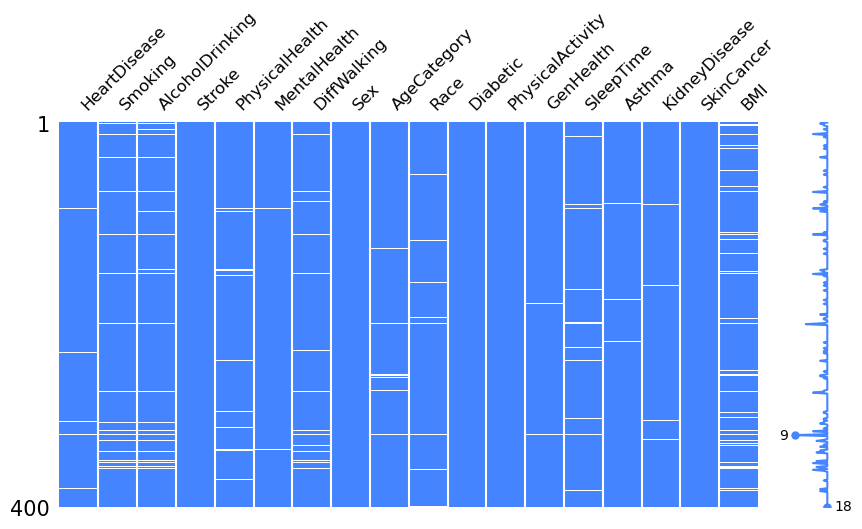

In [5]:
import missingno
missingno.matrix(df, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

In [6]:
df.isna().sum().sum()


140

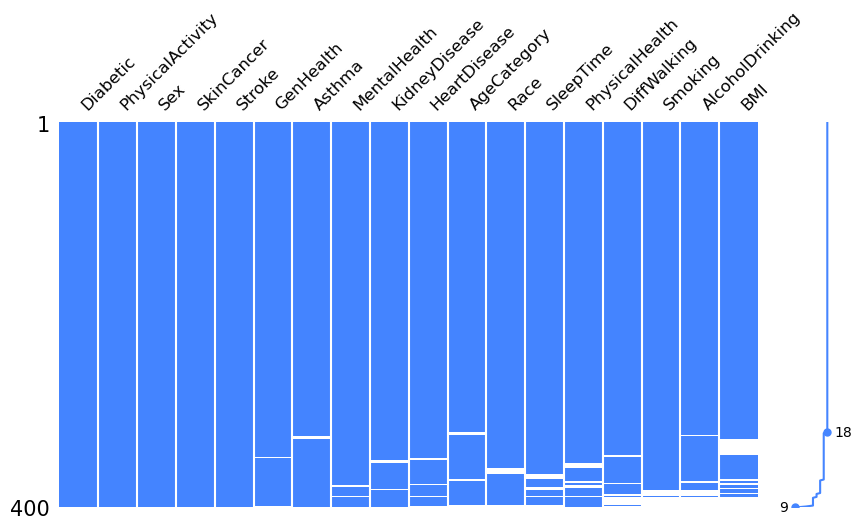

In [7]:
id_matrix = id_matrix_creator(df)

df2, column_vect = lexographical_matrix(df, id_matrix)

missingno.matrix(df2, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

In [8]:
#want an alligned list, one with the rows, and one with the column names

#before lexographical
missingvalsdf = {}
for i in df.columns:
    rows = np.nonzero(pd.isnull(df[i].tolist()))
    missingvalsdf[i] = rows[0].tolist()


In [9]:
#after lexographical

missingvalsdf2 = {}
for i in df2.columns:
    rows = np.nonzero(pd.isnull(df2[i].tolist()))
    missingvalsdf2[i] = rows[0].tolist()


In [10]:
df_binpi = binpi_imputation(df2, column_vect, num_var, bin_var, class_var, weak_learners = 3)


Feature Variable:  AgeCategory 
Missing Values:  140

Iteration 1
Split Found:  n1 [['BMI', 28.286390532544377, 0.013223530769788166, 0]] start
node_proportion_total  0.011287266310981314
Split Found:  n2 [['GenHealth', ('1.0', '2.0', '3.0', '5.0'), 0.021347448992271208, 1]] left
node_proportion_total  0.5761054291797667
Node_proportion_gain  0.5648181628687854
Split Found:  n4 [['SleepTime', 4.0, 0.13694323144104806, 2]] left
node_proportion_total  0.6472761950525127
Node_proportion_gain  0.07117076587274596
This split isn't good now i cut it [counter] - node class purity
TypeError
Split Found:  n9 [['MentalHealth', 0.0, 0.1549320442763065, 3]] right
node_proportion_total  0.6899446434986709
Node_proportion_gain  0.04266844844615825
Split Found:  n5 [['AlcoholDrinking', '0.0', 0.021082022095748266, 2]] right
node_proportion_total  0.718622694675637
Node_proportion_gain  0.02867805117696609
Split Found:  n10 [['MentalHealth', 0.0, 0.056793770139634825, 3]] left
node_proportion_total  

In [11]:
predictors = []
predicted = []
for i in df_binpi.columns:
    for j in missingvalsdf2[i]:
        predictors.append(i)
        predicted.append(df_binpi.loc[j, i])

df_result_binpi = pd.DataFrame(
    {'Predictor':predictors,
     'Predicted Value BINPI': predicted
    })

Sklearn Comparison


In [12]:
from cart import first_nan
from cart import checkNaN
from cart import matches_dict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

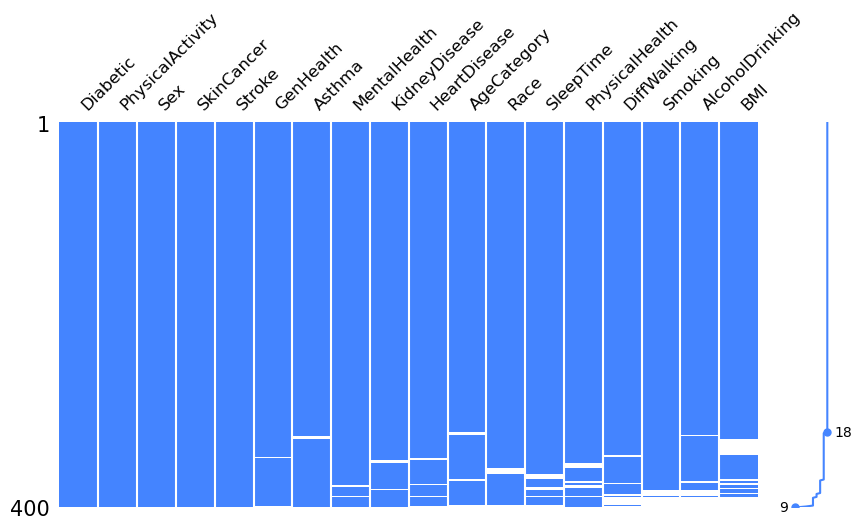

In [13]:
id_matrix = id_matrix_creator(df)

df2, column_vect = lexographical_matrix(df, id_matrix)

missingno.matrix(df2, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

In [14]:
df2.head()

,Diabetic,PhysicalActivity,Sex,SkinCancer,Stroke,GenHealth,Asthma,MentalHealth,KidneyDisease,HeartDisease,AgeCategory,Race,SleepTime,PhysicalHealth,DiffWalking,Smoking,AlcoholDrinking,BMI
0,1.0,1.0,0,1.0,0.0,2.0,1.0,30.0,0.0,0.0,8.0,1.0,5.0,3.0,0.0,1.0,0.0,16.600134
4,3.0,1.0,0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,13.0,1.0,7.0,0.0,0.0,0.0,0.0,20.334711
5,1.0,1.0,1,0.0,0.0,4.0,1.0,30.0,0.0,0.0,10.0,1.0,8.0,20.0,0.0,0.0,0.0,26.578450
6,3.0,0.0,0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,12.0,1.0,6.0,0.0,0.0,0.0,0.0,24.207989
8,3.0,1.0,0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,5.0,1.0,8.0,28.0,1.0,0.0,0.0,23.707598


In [15]:
def imputation_process_sklearn(df2, feature_var, row_no, pos, num_var, bin_var, class_var, old_model_fit = "", old_model="",  previous_var= ""):
  '''Creates an adaboost ensemble based on 3 types of adaboost functionality (depending on variable type) to be used for prediction
  on first missing value, which is then imputed'''
  
  #print(df2.shape)
  complete_df = df2.iloc[0:row_no].copy() 
  complete_df.reset_index(drop = True, inplace = True)  
    
  #print(complete_df.shape, row_no, complete_df.isna().sum().sum())             

  y = complete_df[feature_var]
  complete_df.drop(feature_var, axis = 1, inplace = True)
  X = complete_df
  prediction_feat = df2.iloc[row_no].copy()
  prediction_feat.drop(feature_var, inplace = True)
  
  #print(y.isna().sum())

  #As a temporary fix for multiple missing values, will use mean imputation for a secondary, tertiary etc missing value temporarily 
  for series_name in X.columns:                                  
        if checkNaN(prediction_feat[series_name]):
            if series_name in cat_var:
                prediction_feat[series_name] = Counter(X[series_name][X[series_name].notna()]).most_common(1)[0][0] 
                #print("prediction_feat", series_name ,Counter(X[series_name][X[series_name].notna()]).most_common(1)[0][0])
            else:
                prediction_feat[series_name] = round(mean(X[series_name][X[series_name].notna()]),0)

  imp_time_start = time.time()
  if feature_var in num_var:
    if feature_var != previous_var:
      model = AdaBoostRegressor(random_state = 42)
      model_fit = model.fit(X.values,y.values)
      yhat = model.predict([prediction_feat])
    else:
      yhat = old_model_fit.predict([prediction_feat])
      model, model_fit = old_model, old_model_fit
  
  elif feature_var in bin_var:
    if feature_var != previous_var:
      model = AdaBoostClassifier(random_state = 42)
      model_fit = model.fit(X.values,y.values)
      yhat = model.predict([prediction_feat])
    else:
      yhat = old_model_fit.predict([prediction_feat])
      model, model_fit = old_model, old_model_fit

  elif feature_var in class_var:
    if feature_var != previous_var:
      model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3),  random_state = 42)
      model_fit = model.fit(X.values,y.values)
      yhat = model.predict([prediction_feat]) 
    else:
      yhat = old_model_fit.predict([prediction_feat])
      model, model_fit = old_model, old_model_fit
  else: 
    print("Error, found variable missing from variable lists")

  df2.iloc[row_no, pos-1] = yhat[0]
  previous_var = feature_var

  return model_fit, model, previous_var


In [16]:
dict_match = matches_dict(column_vect)

last_nan = 0
iteration = 0 
while df2.isna().any().any() > 0: #iterates until there arent any na values
  
  start = time.time()
  iteration +=1
  
  row_no, column_vect, last_nan, skip_point = first_nan(df2, column_vect, last_nan)        #finds first nan
  feature_var, pos = feature_variable(df2, row_no)
  
  if skip_point[0]:   #the skip point allows the algorithm to reuse the last generated ensemble
  
    #feature_var, pos = feature_variable(df2, row_no)

    for i in range(dict_match[" ".join(skip_point[3])]):     
  
      if iteration >1:
        model_fit_1, model_1, previous_var_1 = imputation_process_sklearn(df2, feature_var, row_no, pos,  num_var, bin_var, 
                                                                  class_var, old_model_fit, old_model,  previous_var)
      else:
        model_fit_1, model_1, previous_var_1 = imputation_process_sklearn(df2, feature_var, row_no, pos,  num_var, bin_var, class_var)

      old_model_fit, old_model,  previous_var = model_fit_1, model_1, previous_var_1
      
      print("time", time.time() - start)
      iteration +=1
      
      if i >0:
        column_vect[row_no] = (skip_point[1]-1, skip_point[2], skip_point[3]) 
        # for multi missing points, to stop it from going back in
      print(column_vect[row_no])
      row_no+=1
    continue

  feature_var, pos = feature_variable(df2, row_no)
  print("Iteration:",iteration,"/ Row Number of Observation for Prediction:",row_no, "/ Missing Variable:",feature_var)
  
  if iteration >1:
    model_fit_1, model_1, previous_var_1 = imputation_process_sklearn(df2, feature_var, row_no, pos,  num_var, bin_var, class_var, 
                                                              old_model_fit, old_model,  previous_var)
  else:
    model_fit_1, model_1, previous_var_1 = imputation_process_sklearn(df2, feature_var, row_no, pos,  num_var, bin_var, class_var)
  old_model_fit, old_model,  previous_var = model_fit_1, model_1, previous_var_1
  print("time", time.time() - start)

Iteration: 1 / Row Number of Observation for Prediction: 322 / Missing Variable: AgeCategory
time 0.21852612495422363
Iteration: 2 / Row Number of Observation for Prediction: 323 / Missing Variable: AgeCategory
time 0.013000011444091797
Iteration: 3 / Row Number of Observation for Prediction: 324 / Missing Variable: AgeCategory
time 0.008656740188598633
Iteration: 4 / Row Number of Observation for Prediction: 325 / Missing Variable: AlcoholDrinking
time 0.12650322914123535
Iteration: 5 / Row Number of Observation for Prediction: 326 / Missing Variable: Asthma
time 0.12844395637512207
Iteration: 6 / Row Number of Observation for Prediction: 327 / Missing Variable: Asthma
time 0.004934549331665039
Iteration: 7 / Row Number of Observation for Prediction: 328 / Missing Variable: Asthma
time 0.005068540573120117
Iteration: 8 / Row Number of Observation for Prediction: 329 / Missing Variable: BMI
time 0.027904033660888672
Iteration: 9 / Row Number of Observation for Prediction: 330 / Missing

Comparison

In [17]:
df_sklearn = df2.copy()

In [21]:
#predictors = []
predicted = []
for i in df_sklearn.columns:
    for j in missingvalsdf2[i]:
        #predictors.append(i)
        predicted.append(df_sklearn.loc[j, i])

#df_result_sklearn = pd.DataFrame(
#    {'Predictor':predictors,
#     'Predicted Value Sklearn': predicted
#    })

df_result_binpi['Predicted Value Sklearn'] = predicted

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

df_result_binpi.style.hide_index()

Predictor,Predicted Value BINPI,Predicted Value Sklearn
GenHealth,4.0,4.0
GenHealth,4.0,4.0
Asthma,3.0,3.0
Asthma,3.0,3.0
Asthma,3.0,3.0
MentalHealth,0.000000,0.000000
MentalHealth,0.000000,0.000000
MentalHealth,0.000000,0.000000
KidneyDisease,0.0,0.0
KidneyDisease,0.0,0.0


In [ ]:
df_result_binpi

In [24]:
#cat_var = ["ShelveLoc", "Urban", "US"]

disagreements = 0 
total = 0
for i in range(df.isna().sum().sum()):
    if df_result_binpi.loc[i, "Predictor"] in cat_var:
        total +=1
        if df_result_binpi.loc[i, "Predicted Value Sklearn"] != df_result_binpi.loc[i, "Predicted Value BINPI"]:
            disagreements += 1
print(disagreements/total*100,"%")

3.75 %


In [26]:
num_var

['PhysicalHealth', 'MentalHealth', 'SleepTime', 'BMI']

In [25]:
#num_var

avg_diff = 0
total = 0 

for i in range(df.isna().sum().sum()):
    if df_result_binpi.loc[i, "Predictor"] in num_var:
        total +=1
        avg_diff += abs(df_result_binpi.loc[i, "Predicted Value Sklearn"] - df_result_binpi.loc[i, "Predicted Value BINPI"])
avg_diff/total

0.14394640051862606